In [157]:
import torch
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    ShortSideScale,
    UniformTemporalSubsample,
    Div255,
)
from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    Resize,
    RandomHorizontalFlip,
)
from torch.utils.data import DataLoader
import torch.nn as nn
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"


%cd /workspace/Walk_Video_PyTorch/project


/workspace/Walk_Video_PyTorch/project


In [158]:
from pytorch_lightning import seed_everything
from torchmetrics.classification import BinaryAccuracy
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()


seed_everything(42, workers=True)


Global seed set to 42


42

In [159]:
from parameters import get_parameters

VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 8
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

# opt.clip_duration = 2
# opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
# opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = opt.split_pad_data_path


In [160]:
opt.train_path = os.path.join(DATA_PATH, 'flod2')

opt.clip_duration = int(1)
opt.uniform_temporal_subsample_num = int(8)

# ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt'
ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod3/checkpoints/epoch=23-val_loss=0.47-val_acc=0.8568.ckpt'

print('#' * 50)
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()


##################################################
the data path: /workspace/data/split_pad_dataset_512/flod2
ckpt: /workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod3/checkpoints/epoch=23-val_loss=0.47-val_acc=0.8568.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod2
##################################################


In [161]:
transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    # uniform clip T frames from the given n sec video.
                    UniformTemporalSubsample(8),

                    # dived the pixel from [0, 255] tp [0, 1], to save computing resources.
                    Div255(),
                    Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),

                    Resize(size=[224, 224]),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)


In [162]:
from data_loader import WalkDataset
from pytorchvideo.data import make_clip_sampler

dset = WalkDataset(
    data_path='/workspace/Walk_Video_PyTorch/project/misc/test_video/',
    clip_sampler=make_clip_sampler('uniform', 1),
    video_sampler=torch.utils.data.SequentialSampler,
    transform=transform,
)

test_data = DataLoader(
    dset,
    batch_size=300
)


In [163]:
batch = next(iter(test_data))

video = batch['video'].detach()  # b, c, t, h, w
label = batch['label'].detach()  # b, class num
label = [1] * len(label)
name = batch['video_name']

# video.shape, label, name, len(name)


In [164]:
# pred the result
model = model.cuda()
video = video.cuda()

with torch.no_grad():
    pred = model(video)

pred = pred.cpu()


In [165]:
pred_list = []

for i in torch.sigmoid(pred):
    if i > 0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)


In [166]:
# pred_list, label,
len(label)


21

In [167]:
# calc acc
acc = BinaryAccuracy(threshold=0.5)

acc(torch.sigmoid(pred).squeeze(), torch.tensor(label))


tensor(0.4286)

('0001', array([0.89888504, 0.30549789, 0.20676663, 1.        ]))
('0002', array([0.98039216, 0.59738562, 0.34117647, 1.        ]))
('0003', array([0.99546328, 0.84767397, 0.51926182, 1.        ]))
('0004', array([0.99707805, 0.9987697 , 0.74502115, 1.        ]))
('0005', array([0.81960784, 0.92372165, 0.52479815, 1.        ]))
('0006', array([0.56732026, 0.81437908, 0.40653595, 1.        ]))
('0007', array([0.24805844, 0.66720492, 0.3502499 , 1.        ]))


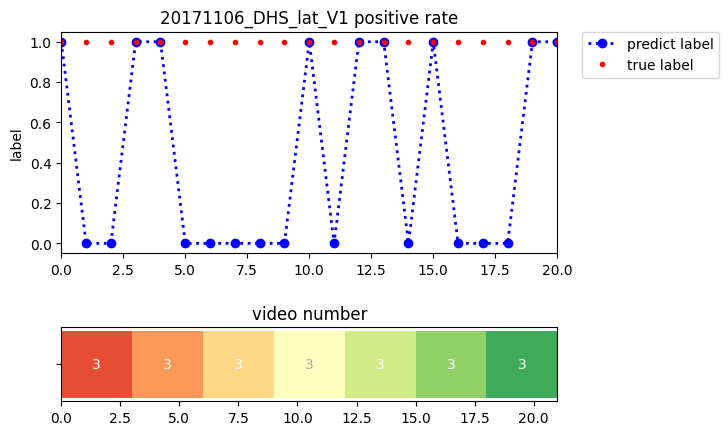

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

number_list = []

for i, _ in enumerate(name):
    number = _.split('-')[1].split('.')[0]
    number_list.append(number)

category_names = list(set(number_list))
category_names.sort()

results = {
    '': list(Counter(number_list).values())
}


def survey(results, category_names, pred: list, label: list, video_num: int):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1.5, 0.5]})
    ax[1].invert_yaxis()
    ax[1].set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        print((colname, color))
        widths = data[:, i]
        starts = data_cum[:, i] - widths

        rects = ax[1].barh(labels, widths, left=starts, height=0.1,
                           label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'

        ax[1].bar_label(rects, label_type='center', color=text_color)

    ax[1].set_title('video number')

    # 生成图形
    ax[0].plot(video_number, pred, 'bo:', label='predict label', linewidth=2)  # 颜色绿色，点形圆形，线性虚线，设置图例显示内容，线条宽度为2
    ax[0].plot(video_number, label, 'r.', label='true label', linewidth=1)

    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # 显示图例, 图例中内容由 label 定义
    ax[0].set_title('%s positive rate' % name[0].split('-')[0])  # 图形的标题
    ax[0].set_ylabel('label')
    ax[0].autoscale(enable=True, axis="x", tight=True)

    fig.subplots_adjust(hspace=0.5) # 甚至两个图片中间的距离

    return fig, ax


# 生成数据
video_number = range(0, len(label))
pred = pred_list
label = label

fig, ax = survey(results, category_names, pred, label, video_number)

# ax[0].ylabel('label') # 横坐标轴的标题
# ax[0].xlabel('video number') # 纵坐标轴的标题
# ax[0].xticks(range(0, len(label))) # 设置横坐标轴的刻度为 0 到 10 的数组
# ax[0].ylim([-0.25, 1.25]) # 设置纵坐标轴范围为 -2 到 2

plt.show()


In [169]:
video_01 = video[13:16]
video_01.shape

torch.Size([3, 3, 8, 224, 224])

In [170]:
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# guided grad cam method
target_layer = [model.model.blocks[-2].res_blocks[-1]]
# target_layer = [ model.model.blocks[-2]]

cam = LayerCAM(model, target_layer, use_cuda=True)

targets = [ClassifierOutputTarget(-1)]

grayscale_cam = cam(video_01, aug_smooth=True, eigen_smooth=True)

grayscale_cam.shape

KeyboardInterrupt: 

In [ ]:
grayscale_cam[0, :, :, 6].shape, video_01[0, :, 6, :].permute(1,2,0).cpu().detach().numpy().shape

((224, 224), (224, 224, 3))

In [ ]:
cam_map = grayscale_cam.mean(axis=3).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 3)

cam_map.shape, type(cam_map)

((3, 224, 224, 1), numpy.ndarray)

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


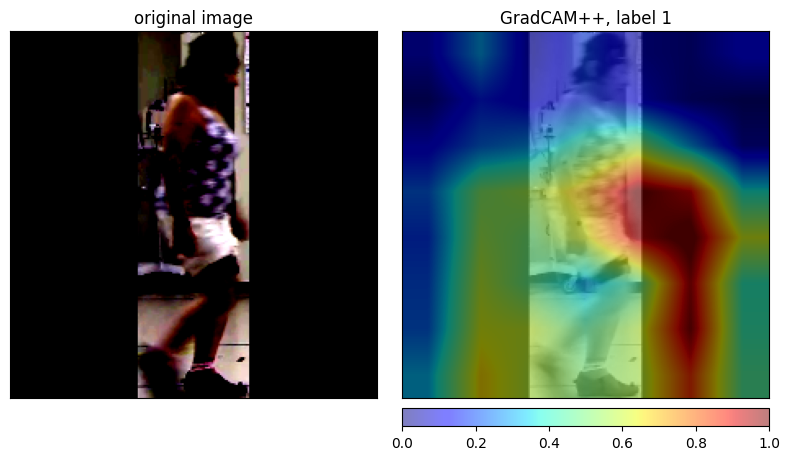

In [ ]:
from captum.attr import visualization as viz

figure, axis = viz.visualize_image_attr_multiple(
    cam_map[2],
    video_01[2, :, 5, :].permute(1,2,0).cpu().detach().numpy(),
    methods=['original_image', 'blended_heat_map'],
    signs=['all', 'positive'],
    show_colorbar=True,
    outlier_perc=1, 
    cmap='jet',
    titles=['original image', 'GradCAM++, label %s' % int(1)]
)

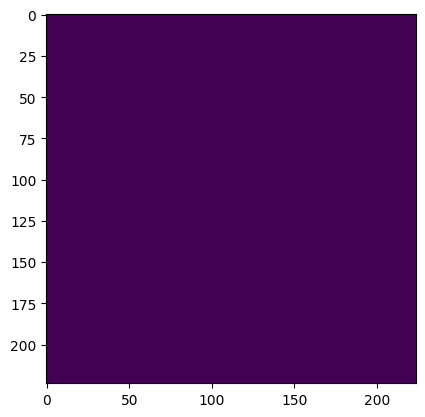

In [ ]:
import matplotlib.pyplot as plt 

plt.imshow(grayscale_cam[2, :, :, 0])

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


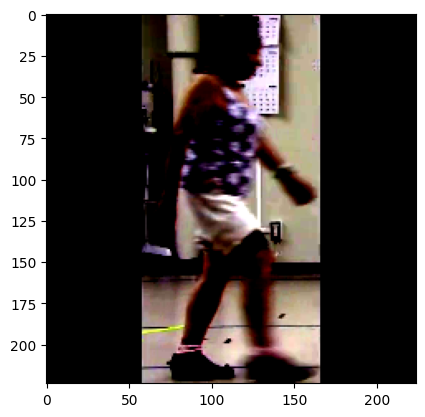

In [ ]:
print(video_01[0, :, 0, :].permute(1,2,0).shape)
plt.imshow(video_01[2, :, 6, :].permute(1,2,0).cpu())

In [ ]:
cam_map = grayscale_cam.mean(axis=3).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 2)

cam_map.shape, type(cam_map)

((4, 224, 1, 224), numpy.ndarray)

In [ ]:
from torchinfo import summary

summary(model, input_size=(4, 3, 8, 224, 224), col_names=['input_size', 'output_size'])

Layer (type:depth-idx)                                  Input Shape               Output Shape
WalkVideoClassificationLightningModule                  [4, 3, 8, 224, 224]       [4, 1]
├─Net: 1-1                                              [4, 3, 8, 224, 224]       [4, 1]
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ResNetBasicStem: 3-1                        [4, 3, 8, 224, 224]       [4, 64, 8, 56, 56]
│    │    └─ResStage: 3-2                               [4, 64, 8, 56, 56]        [4, 256, 8, 56, 56]
│    │    └─ResStage: 3-3                               [4, 256, 8, 56, 56]       [4, 512, 8, 28, 28]
│    │    └─ResStage: 3-4                               [4, 512, 8, 28, 28]       [4, 1024, 8, 14, 14]
│    │    └─ResStage: 3-5                               [4, 1024, 8, 14, 14]      [4, 2048, 8, 7, 7]
│    │    └─ResNetBasicHead: 3-6                        [4, 2048, 8, 7, 7]        [4, 1]
├─BinaryAccuracy: 1-2                       